# Example using a 2D Gaussian

In [3]:
import torch
import sbi.utils as utils
from sbi.inference import SNPE, SNLE, SNRE
import seaborn as sns
from matplotlib import pyplot as plt
from sbi.analysis import pairplot
import numpy as np

ImportError: dlopen(/Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/torch/_C.cpython-310-darwin.so, 0x0002): Symbol not found: __ZN6google8protobuf5Arena18CreateMaybeMessageIN10onnx_torch10GraphProtoEJEEEPT_PS1_DpOT0_
  Referenced from: <7DB42472-0B0A-3488-BDF2-EE4CB6155885> /Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <1F1D80B0-A695-3C81-AD64-A520121567F5> /Users/jonathanhering/miniforge3/envs/sbi_env/lib/libtorch_cpu.dylib

The simulator will take an estimate for $\mu$ (drawn from our prior distribution) and output a "simulation result" as a random sample of a Gaussian. 
## 1. Learn the posterior from the simulator

In [ ]:
# Uniform prior to generate proposals for \mu
prior = utils.BoxUniform(low=torch.tensor([-5., -5.]),
                         high=torch.tensor([5., 5.]))

# Simulator given \mu
def simulator(mu):
    return mu + 0.5 * torch.randn_like(mu)

The simulator will take an estimate for $\mu$ (drawn from our prior distribution) and output a "simulation result" as a random sample of a Gaussian. 
## 1. Learn the posterior from the simulator

In [ ]:
num_sim = 2000
method = 'SNPE'

# Setup inference method
if method == 'SNPE':
    inference = SNPE(prior)
elif method == 'SNLE':
    inference = SNLE(prior)
elif method == 'SNRE':
    inference = SNRE(prior)
else:
    raise ValueError(f"Unknown method: {method}")

# Manual simulation loop
theta_list, x_list = [], []
for _ in range(num_sim):
    theta = prior.sample((1,))
    x = simulator(theta)
    theta_list.append(theta)
    x_list.append(x)

# Stack results
theta = torch.cat(theta_list, dim=0)
x = torch.cat(x_list, dim=0)

# Train posterior
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)


 Neural network successfully converged after 106 epochs.

## 2. Record 5 "observations" of the true distribution

In [ ]:
n_obs = 5
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_obs, 2)

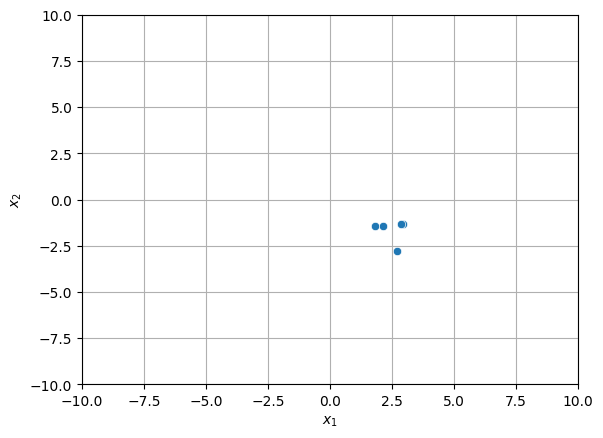

In [ ]:
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.grid()
plt.show()

Now we can use our learned likelihood (NN) to do inference on it
## 3. Inference


In [ ]:
samples = posterior.sample((num_sim,), x=observation[0])

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:00<00:00, 89102.12it/s]


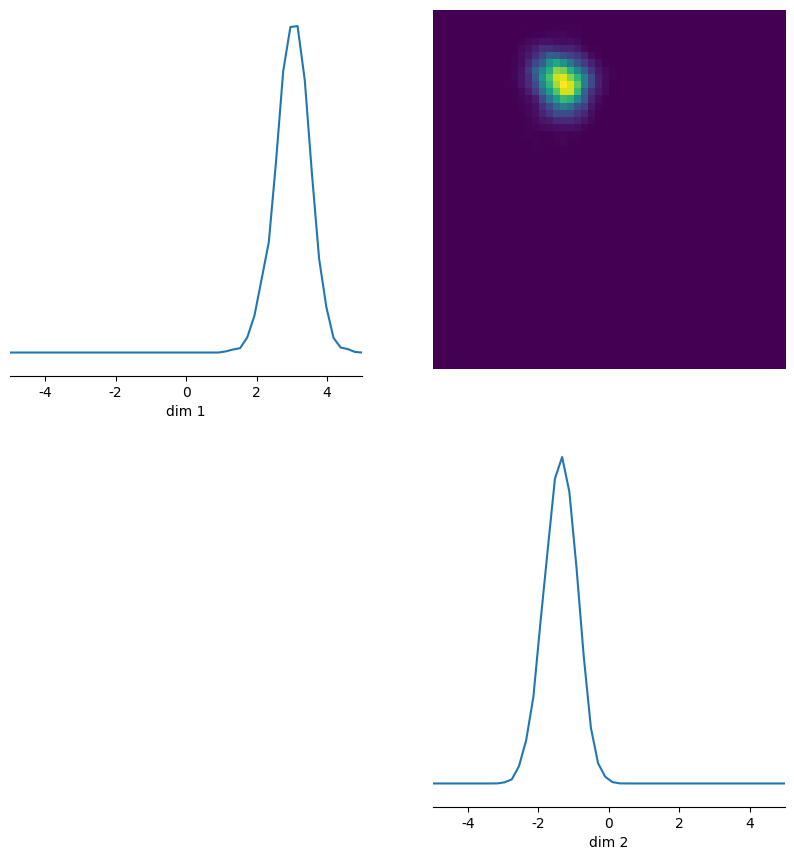

In [ ]:
log_probability = posterior.log_prob(samples, x=observation[0])
out = pairplot(samples, limits=[[-5,5],[-5,5]], fig_size=(6,6), upper='kde', diag='kde')

## Compute log-probability

Create a grid of $\mu$ close to the expected value of (3, -1.5) and calculate the total log likelihood:

In [ ]:
bounds = [3-1, 3+1, -1.5-1, -1.5+1]

mu_1, mu_2 = torch.tensor(np.mgrid[bounds[0]:bounds[1]:2/50., bounds[2]:bounds[3]:2/50.]).float()

grids = torch.cat((mu_1.reshape(-1, 1), mu_2.reshape(-1, 1)),dim=1)

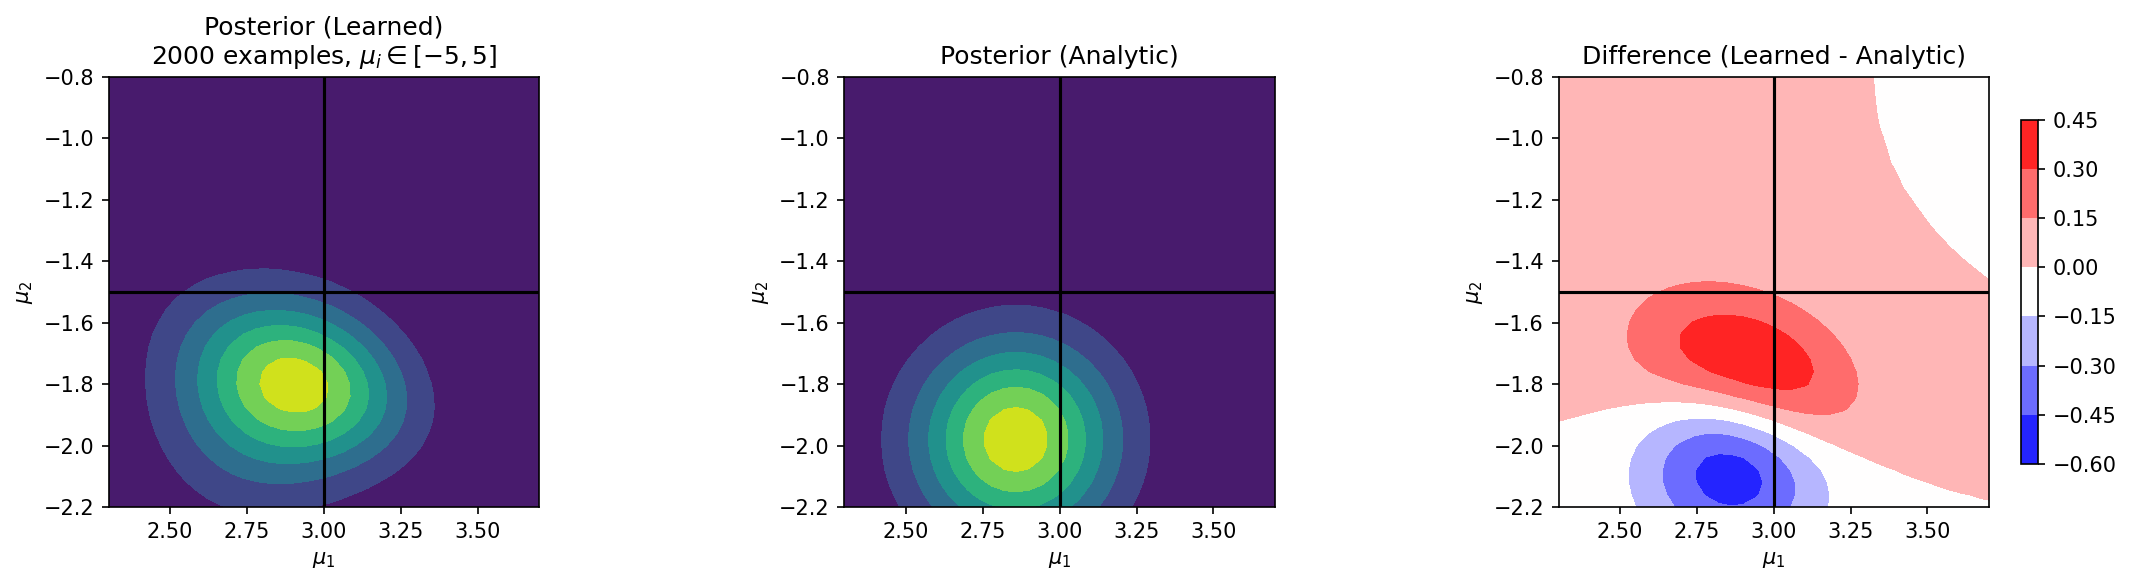

In [ ]:
# --- Compute learned posterior ---
if method == 'SNPE':
    log_prob_learned = sum([
        posterior.log_prob(grids, observation[i])
        for i in range(len(observation))
    ])
else:
    log_prob_learned = sum([
        posterior.net(torch.cat((grids, observation[i].repeat((grids.shape[0])).reshape(-1, 2)), dim=1))[:, 0]
        + posterior._prior.log_prob(grids)
        for i in range(len(observation))
    ]).detach()

prob_learned = torch.exp(log_prob_learned - log_prob_learned.max()).reshape(*mu_1.shape)

# --- Compute analytic posterior ---
true_like = lambda x: -((x[0] - mu_1)**2 + (x[1] - mu_2)**2) / (2 * 0.5**2)
log_prob_analytic = sum([true_like(observation[i]) for i in range(len(observation))])
prob_analytic = torch.exp(log_prob_analytic - log_prob_analytic.max())

# --- Compute difference ---
prob_diff =  prob_learned - prob_analytic

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150)

# Plot learned posterior
axes[0].contourf(prob_learned, extent=bounds, origin='lower')
axes[0].plot([2, 4], [-1.5, -1.5], color='k')
axes[0].plot([3, 3], [-0.5, -2.5], color='k')
axes[0].set_title(f'Posterior (Learned)\n{num_sim} examples, $\\mu_i \\in [-5, 5]$')
axes[0].set_xlabel(r'$\mu_1$')
axes[0].set_ylabel(r'$\mu_2$')
axes[0].axis('scaled')
axes[0].set_xlim(2+0.3, 4-0.3)
axes[0].set_ylim(-2.5+0.3, -0.5-0.3)

# Plot analytic posterior
axes[1].contourf(prob_analytic, extent=bounds, origin='lower')
axes[1].plot([2, 4], [-1.5, -1.5], color='k')
axes[1].plot([3, 3], [-0.5, -2.5], color='k')
axes[1].set_title('Posterior (Analytic)')
axes[1].set_xlabel(r'$\mu_1$')
axes[1].set_ylabel(r'$\mu_2$')
axes[1].axis('scaled')
axes[1].set_xlim(2+0.3, 4-0.3)
axes[1].set_ylim(-2.5+0.3, -0.5-0.3)

# Plot difference
pcm = axes[2].contourf(prob_diff, extent=bounds, origin='lower', cmap='bwr')
axes[2].plot([2, 4], [-1.5, -1.5], color='k')
axes[2].plot([3, 3], [-0.5, -2.5], color='k')
axes[2].set_title('Difference (Learned - Analytic)')
axes[2].set_xlabel(r'$\mu_1$')
axes[2].set_ylabel(r'$\mu_2$')
axes[2].axis('scaled')
axes[2].set_xlim(2+0.3, 4-0.3)
axes[2].set_ylim(-2.5+0.3, -0.5-0.3)
fig.colorbar(pcm, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.show()

## Ratio estimation for 2D gaussian

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import emcee
import corner
import matplotlib.pyplot as plt

# === Forward model: 2D Gaussian ===
def gaussian_simulator(mu):
    cov = np.array([[1.0, 0.0], [0.0, 1.0]])  # fixed identity covariance
    return np.random.multivariate_normal(mu, cov, size=100).mean(axis=0)

# Generate training data
n_train = 50000
theta_samples = np.random.uniform(low=[-5, -5], high=[5, 5], size=(n_train, 2))  # means
x_samples = np.array([gaussian_simulator(mu) for mu in tqdm(theta_samples)])

# Convert to tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize
x_mean, x_std = x_samples.mean(0), x_samples.std(0)
theta_mean, theta_std = theta_samples.mean(0), theta_samples.std(0)
x_samples = (x_samples - x_mean) / x_std
theta_samples = (theta_samples - theta_mean) / theta_std

# === MLP Classifier ===
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

class NeuralRatioEstimator(pl.LightningModule):
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(x_dim + theta_dim, 128, 1, 4)

    def forward(self, x):
        return self.classifier(x)

    def loss(self, x, theta):
        x = x.repeat_interleave(2, dim=0)
        theta_shuffled = theta[torch.randperm(theta.shape[0])]
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])
        labels = torch.ones(x.shape[0], device=x.device)
        labels[1::2] = 0.0
        logits = self(torch.cat([x, theta], dim=1)).squeeze()
        return nn.BCELoss()(torch.sigmoid(logits), labels)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Dataset & training
val_fraction = 0.1
n_val = int(len(x_samples) * val_fraction)
train_set, val_set = random_split(TensorDataset(x_samples, theta_samples), [len(x_samples)-n_val, n_val])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)

nre = NeuralRatioEstimator(x_dim=2, theta_dim=2)
trainer = pl.Trainer(max_epochs=20, logger=False, enable_checkpointing=False)
trainer.fit(nre, train_loader, val_loader)

# === Define posterior for inference ===
def log_prior(theta):
    if np.all((-5 <= theta) & (theta <= 5)):
        return 0.0
    return -np.inf

def log_like(theta, x_obs):
    x_torch = (torch.tensor(x_obs, dtype=torch.float32) - x_mean) / x_std
    theta_torch = (torch.tensor(theta, dtype=torch.float32) - theta_mean) / theta_std
    with torch.no_grad():
        logit = nre.classifier(torch.cat([x_torch, theta_torch], dim=0)).item()
    return logit

def log_post(theta, x_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x_obs)

# === Inference ===
theta_true = np.array([2.0, -1.0])
x_obs = gaussian_simulator(theta_true)

ndim, nwalkers = 2, 32
pos = theta_true + 1e-2 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_obs,))
sampler.run_mcmc(pos, 3000, progress=True)

samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(samples, labels=[r"$\mu_1$", r"$\mu_2$"], truths=theta_true);

ImportError: dlopen(/Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/torch/_C.cpython-310-darwin.so, 0x0002): Symbol not found: __ZN6google8protobuf5Arena18CreateMaybeMessageIN10onnx_torch10GraphProtoEJEEEPT_PS1_DpOT0_
  Referenced from: <7DB42472-0B0A-3488-BDF2-EE4CB6155885> /Users/jonathanhering/miniforge3/envs/sbi_env/lib/python3.10/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <1F1D80B0-A695-3C81-AD64-A520121567F5> /Users/jonathanhering/miniforge3/envs/sbi_env/lib/libtorch_cpu.dylib